<a href="https://colab.research.google.com/github/Marzukkhan/Mie350Proj/blob/main/DeeperAutoencoderSmallerLearningRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Anime faces 
# puts images into colab
# following code must be ran once at the beginning of each new runtime

# Source: https://www.kaggle.com/general/74235
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download splcher/animefacedataset --unzip --force

import shutil
!mkdir anime_faces
shutil.move("/content/images", "/content/anime_faces") 

Saving kaggle.json to kaggle.json
 98% 385M/395M [00:03<00:00, 116MB/s]
100% 395M/395M [00:03<00:00, 120MB/s]


'/content/anime_faces/images'

In [4]:
# Human faces
# puts images into colab
# following code must be ran once at the beginning of each new runtime

# Source: https://colab.research.google.com/drive/1ytjiIM_sZohV1I6p-9Cov6DtJjidJmcq#scrollTo=BALJJFbe3hNb
import zipfile

!mkdir human_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("human_faces/")

--2023-03-17 22:29:13--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.8
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  65.5MB/s    in 21s     

2023-03-17 22:29:34 (64.6 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
########## code below is the standard "getting data and splitting into train/validation/testing" code 

In [5]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Anime Images dataloader
def get_dataloader_anime(batch_size):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Resize([224,224]), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# update directory below to your directory!
  dataset = torchvision.datasets.ImageFolder("./anime_faces",transform=transform)

  # split data into training, validation, testing 
  indices = list(range(len(dataset)))
  np.random.seed(1)
  np.random.shuffle(indices)
  split1 = int(len(indices) * 0.7) # split at 70% 
  split2 = int(len(indices) * 0.2) # split at 20%
  # train:validate:test = 7:2:1

  train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=val_sampler)
  testing_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=test_sampler)

  return training_loader, validation_loader, testing_loader

In [7]:
# Human Images dataloader
def get_dataloader_human(batch_size):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Resize([224,224]), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  # load the dataset 
  dataset = datasets.ImageFolder('./human_faces', transform=transform, target_transform=lambda x:1)

  # split data into training, validation, testing 
  indices = list(range(len(dataset)))
  np.random.seed(1)
  np.random.shuffle(indices)
  split1 = int(len(indices) * 0.7) # split at 70% 
  split2 = int(len(indices) * 0.2) # split at 20%
  # train:validate:test = 7:2:1

  train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=val_sampler)
  testing_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=test_sampler)

  return training_loader, validation_loader, testing_loader

In [8]:
def get_dataloader_combined(batch_size):
  transform = transforms.Compose(
          [transforms.ToTensor(), transforms.Resize([224,224]), 
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  # load the dataset 
  dataset1 = torchvision.datasets.ImageFolder("./anime_faces",transform=transform)
  dataset2 = datasets.ImageFolder('./human_faces', transform=transform, target_transform=lambda x:1)

  dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])
  # split data into training, validation, testing 
  indices = list(range(len(dataset)))
  np.random.seed(1)
  np.random.shuffle(indices)
  split1 = int(len(indices) * 0.05) # split at 70% 
  split2 = int(len(indices) * 0.075) # split at 20%
  # train:validate:test = 7:2:1

  train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
  train_sampler = SubsetRandomSampler(train_indices)
  val_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)

  training_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=train_sampler)
  validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=val_sampler)
  testing_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                num_workers=2, sampler=test_sampler)

  return training_loader, validation_loader, testing_loader

In [15]:
batch_size = 200
# Anime images dataloader 
training_loader_anime, validation_loader_anime, testing_loader_anime = get_dataloader_anime(batch_size)

# Human images dataloader
training_loader_human, validation_loader_human, testing_loader_human = get_dataloader_human(batch_size)

In [16]:
def show(img,renorm=False,nrow=8,interpolation='bicubic'):
  if renorm:
    img = img/2 + 0.5
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation=interpolation)
  plt.axis('off')
  plt.show()

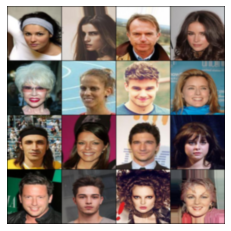

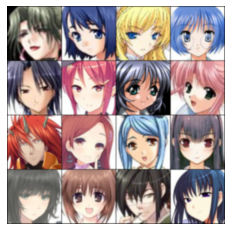

In [17]:
batch, _ = next(iter(training_loader_human))
show(batch[0:16], renorm = True, nrow=4)

batch, _ = next(iter(training_loader_anime))
show(batch[0:16], renorm = True, nrow=4)

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 16, 3, stride=2, padding=1), #image size 224x224 
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), #112x112
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), #56x56
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), #23x23
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2, padding=1), #12x12
            nn.ReLU(),
            nn.Conv2d(64, 64, 7), #4x4
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
            )
        self.fc2 = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(64, 64, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1,64)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(-1,64,1,1)
        x = self.decoder(x)
        return x

In [26]:
def train_autoencoder(model, num_epochs=5, batch_size=64, learning_rate=0.0001):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    train_loader, val_loader, test_loader = get_dataloader_anime(batch_size)
    iters, train_losses = [], []
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img, _ = img.cuda(), _.cuda()
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        iters.append(epoch)
        train_losses.append(float(loss))
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    return outputs

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()               

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=452ee45f1dbc24db6011f708113444b4088d32f59753fb65a4647c62293b9683
  Stored in directory: /root/.cache/pip/wheels/2b/b5/24/fbb56595c286984f7315ee31821d6121e1b9828436021a88b3
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 27% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 | 44% |  1% |


In [29]:
a = Autoencoder()
a.cuda()
train_autoencoder(a, num_epochs=50, batch_size=500)

Epoch:1, Loss:0.3783
Epoch:2, Loss:0.2825
Epoch:3, Loss:0.2356
Epoch:4, Loss:0.2084
Epoch:5, Loss:0.2014
Epoch:6, Loss:0.1929
Epoch:7, Loss:0.1851
Epoch:8, Loss:0.1863
Epoch:9, Loss:0.1806
Epoch:10, Loss:0.1807
Epoch:11, Loss:0.1738
Epoch:12, Loss:0.1776
Epoch:13, Loss:0.1775
Epoch:14, Loss:0.1757
Epoch:15, Loss:0.1696
Epoch:16, Loss:0.1661
Epoch:17, Loss:0.1660
Epoch:18, Loss:0.1722
Epoch:19, Loss:0.1663
Epoch:20, Loss:0.1709
Epoch:21, Loss:0.1657
Epoch:22, Loss:0.1638
Epoch:23, Loss:0.1626
Epoch:24, Loss:0.1672
Epoch:25, Loss:0.1629
Epoch:26, Loss:0.1654
Epoch:27, Loss:0.1642
Epoch:28, Loss:0.1678
Epoch:29, Loss:0.1616
Epoch:30, Loss:0.1616
Epoch:31, Loss:0.1642
Epoch:32, Loss:0.1605
Epoch:33, Loss:0.1558
Epoch:34, Loss:0.1643
Epoch:35, Loss:0.1581
Epoch:36, Loss:0.1599
Epoch:37, Loss:0.1629


KeyboardInterrupt: ignored

In [ ]:
torch.save(a.state_dict(), "DeeperAutoencoder_Anime")

In [ ]:
class Autoencoderhuman(nn.Module):
    def __init__(self):
        super(Autoencoderhuman, self).__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train_autoencoder2(model, num_epochs=5, batch_size=64, learning_rate=0.01):
    torch.manual_seed(43)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    train_loader, val_loader, test_loader = get_dataloader_human(batch_size)
    iters, train_losses = [], []
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img, _ = img.cuda(), _.cuda()
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        iters.append(epoch)
        train_losses.append(float(loss))
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    return outputs

Epoch:1, Loss:0.2728
Epoch:2, Loss:0.2656
Epoch:3, Loss:0.2776
Epoch:4, Loss:0.2750
Epoch:5, Loss:0.2692
Epoch:6, Loss:0.2485
Epoch:7, Loss:0.2493
Epoch:8, Loss:0.2427
Epoch:9, Loss:0.2491
Epoch:10, Loss:0.2452


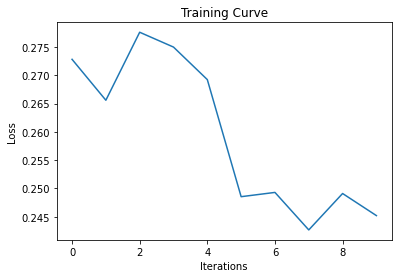

[(0, tensor([[[[ 0.5373,  0.5373,  0.5373,  ...,  0.5451,  0.5451,  0.5451],
            [ 0.5373,  0.5373,  0.5373,  ...,  0.5451,  0.5451,  0.5451],
            [ 0.5373,  0.5373,  0.5373,  ...,  0.5451,  0.5451,  0.5451],
            ...,
            [-0.7412, -0.7361, -0.7341,  ...,  0.6428,  0.6148,  0.6199],
            [-0.7412, -0.7412, -0.7450,  ...,  0.6416,  0.7078,  0.7838],
            [-0.7412, -0.7412, -0.7450,  ...,  0.4007,  0.6025,  0.6784]],
  
           [[ 0.5216,  0.5216,  0.5216,  ...,  0.5451,  0.5451,  0.5451],
            [ 0.5216,  0.5216,  0.5216,  ...,  0.5451,  0.5451,  0.5451],
            [ 0.5216,  0.5216,  0.5216,  ...,  0.5451,  0.5451,  0.5451],
            ...,
            [-0.7412, -0.7361, -0.7341,  ...,  0.6535,  0.6148,  0.6199],
            [-0.7412, -0.7412, -0.7450,  ...,  0.6416,  0.7078,  0.7838],
            [-0.7412, -0.7412, -0.7450,  ...,  0.4007,  0.6025,  0.6784]],
  
           [[ 0.6078,  0.6078,  0.6078,  ...,  0.6392,  0.6392,  0.

In [ ]:
b = Autoencoderhuman()
b.cuda()
train_autoencoder2(b, num_epochs=10, batch_size=1000)

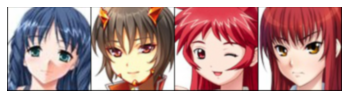

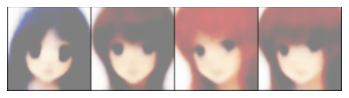

In [ ]:
train_loader, val_loader, test_loader = get_dataloader_anime(batch_size)
for data in train_loader:
  img, _ = data
  img, _ = img.cuda(), _.cuda()
  break

output = a(img)
show(img[0:4].cpu(), renorm=True, nrow=4)
show(output[0:4].cpu(), renorm=True, nrow=4)

tensor([[[[7.6081e-01, 8.1437e-01, 8.2171e-01,  ..., 7.9255e-01,
           7.8617e-01, 6.7067e-01],
          [8.0605e-01, 8.1364e-01, 8.3656e-01,  ..., 8.0828e-01,
           8.3097e-01, 7.1785e-01],
          [8.1689e-01, 8.4070e-01, 8.4545e-01,  ..., 8.3282e-01,
           7.8380e-01, 7.1793e-01],
          ...,
          [6.6470e-01, 6.9207e-01, 7.0519e-01,  ..., 6.9238e-01,
           7.1221e-01, 6.0203e-01],
          [5.8582e-01, 6.2099e-01, 6.3001e-01,  ..., 6.9427e-01,
           6.0406e-01, 5.6914e-01],
          [5.6504e-01, 6.1244e-01, 6.0818e-01,  ..., 6.0498e-01,
           6.0197e-01, 5.4952e-01]],

         [[7.8587e-01, 8.2783e-01, 8.6492e-01,  ..., 7.5580e-01,
           7.8296e-01, 6.6298e-01],
          [8.1698e-01, 8.5186e-01, 8.8779e-01,  ..., 8.0583e-01,
           8.1481e-01, 6.8588e-01],
          [8.2889e-01, 8.5365e-01, 8.8753e-01,  ..., 8.0639e-01,
           7.9231e-01, 7.0105e-01],
          ...,
          [3.5938e-01, 3.9208e-01, 4.2829e-01,  ..., 4.3973

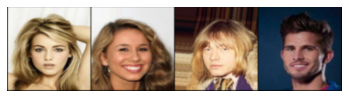

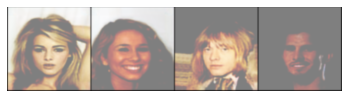

In [ ]:
training_loader_human, validation_loader_human, testing_loader_human = get_dataloader_human(batch_size)
for data in testing_loader_human:
  imgs, _ = data
  imgs, _ = imgs.cuda(), _.cuda()
  break

outputas = b(imgs)
print(outputas)
show(imgs[0:4].cpu(), renorm=True, nrow=4)
show(outputas[0:4].cpu(), renorm=True, nrow=4)

In [ ]:
autoencoder_human = Autoencoder()
autoencoder_anime = Autoencoder()
autoencoder_human.load_state_dict(torch.load("/content/autoencoder_human"))
autoencoder_anime.load_state_dict(torch.load("/content/autoencoder_anime"))
